In [4]:
import os
import numpy as np
from astropy.io import fits
import logging
from concurrent.futures import ThreadPoolExecutor
import random

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def convert_fits_to_npy(fits_file, npy_file, target_length=3748):
    """Converts a single FITS file to NumPy format."""
    try:
        with fits.open(fits_file) as hdul:
            if len(hdul) > 0:  # Check if the Primary HDU exists
                spectra_data = hdul[0].data  # Assuming the spectra data is in the Primary HDU
                if spectra_data is not None:
                    spectra_data = spectra_data[:target_length]  # Trim to target length if necessary
                    
                    # Save to NumPy array
                    np.save(npy_file, spectra_data)
                else:
                    logging.error(f"{fits_file} does not contain data in the Primary HDU")
            else:
                logging.error(f"{fits_file} does not contain the expected HDU")
    except Exception as e:
        logging.error(f"Error converting {fits_file} to {npy_file}: {e}")

def batch_convert_fits_to_npy(file_list, target_dir, target_length=3748):
    """Convert a batch of FITS files to NumPy format."""
    os.makedirs(target_dir, exist_ok=True)  # Create target directory if it doesn't exist
    
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(convert_fits_to_npy, fits_file, os.path.join(target_dir, os.path.splitext(os.path.basename(fits_file))[0] + ".npy"), target_length) for fits_file in file_list]
        for future in futures:
            future.result()  # Wait for all threads to complete

    logging.info(f"All FITS files converted to NumPy arrays and saved in {target_dir}")

def generate_file_list_from_directories(base_dirs, limit_per_dir=10000):
    """Generates a list of files and labels from the pre-separated directories."""
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    logging.info("Gathering FITS files from pre-separated directories...")
    for dir_name, label in spectra_dirs.items():
        for base_dir in base_dirs:
            dir_path = os.path.join(base_dir, dir_name)
            if os.path.exists(dir_path):
                logging.info(f"Checking directory: {dir_path}")
                dir_files = os.listdir(dir_path)
                logging.info(f"Found {len(dir_files)} files in {dir_path}")

                # Collect all files in the directory
                current_file_list = []
                for file in dir_files:
                    file_path = os.path.join(dir_path, file)
                    current_file_list.append(file_path)

                # Randomly select files up to the limit
                if len(current_file_list) > limit_per_dir:
                    selected_files = random.sample(current_file_list, limit_per_dir)
                else:
                    selected_files = current_file_list

                # Append selected files and their labels
                file_list.extend(selected_files)
                labels.extend([label] * len(selected_files))

    logging.info(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels

# Convert all FITS files to NumPy arrays
train_files, train_labels = generate_file_list_from_directories(["training_set"], limit_per_dir=10000)
val_files, val_labels = generate_file_list_from_directories(["validation_set"], limit_per_dir=10000)

batch_convert_fits_to_npy(train_files, "training_npy")
batch_convert_fits_to_npy(val_files, "validation_npy")


2024-10-01 16:12:43,251 - INFO - Gathering FITS files from pre-separated directories...
2024-10-01 16:12:43,253 - INFO - Checking directory: training_set/gal_spectra
2024-10-01 16:12:43,258 - INFO - Found 1699 files in training_set/gal_spectra
2024-10-01 16:12:43,261 - INFO - Checking directory: training_set/star_spectra
2024-10-01 16:12:43,430 - INFO - Found 86037 files in training_set/star_spectra
2024-10-01 16:12:43,494 - INFO - Checking directory: training_set/agn_spectra
2024-10-01 16:12:43,561 - INFO - Found 35936 files in training_set/agn_spectra
2024-10-01 16:12:43,585 - INFO - Checking directory: training_set/bin_spectra
2024-10-01 16:12:43,655 - INFO - Found 40676 files in training_set/bin_spectra
2024-10-01 16:12:43,686 - INFO - Total spectra files collected: 31699
2024-10-01 16:12:43,689 - INFO - Gathering FITS files from pre-separated directories...
2024-10-01 16:12:43,690 - INFO - Checking directory: validation_set/gal_spectra
2024-10-01 16:12:43,692 - INFO - Found 400 fi

In [1]:
import os
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from astropy.io import fits
import numpy as np
import random
from tqdm import tqdm  # Added for progress bar

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def convert_fits_to_npy(fits_file, npy_file, target_length=3748):
    """Converts a single FITS file to NumPy format."""
    try:
        with fits.open(fits_file) as hdul:
            if len(hdul) > 0:  # Check if the Primary HDU exists
                spectra_data = hdul[0].data  # Assuming the spectra data is in the Primary HDU
                if spectra_data is not None:
                    spectra_data = spectra_data[:target_length]  # Trim to target length if necessary
                    
                    # Save to NumPy array
                    np.save(npy_file, spectra_data)
                else:
                    logging.error(f"{fits_file} does not contain data in the Primary HDU")
            else:
                logging.error(f"{fits_file} does not contain the expected HDU")
    except Exception as e:
        logging.error(f"Error converting {fits_file} to {npy_file}: {e}")

def batch_convert_fits_to_npy(file_list, base_target_dir, target_length=3748, max_workers=8):
    """Convert a batch of FITS files to NumPy format."""
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for fits_file in tqdm(file_list, desc="Converting FITS to NumPy"):  # Added progress bar
            # Determine the subdirectory structure
            sub_dir = os.path.relpath(os.path.dirname(fits_file), start=os.path.commonpath(file_list))
            target_dir = os.path.join(base_target_dir, sub_dir)
            os.makedirs(target_dir, exist_ok=True)  # Create target subdirectory if it doesn't exist
            
            npy_file = os.path.join(target_dir, os.path.splitext(os.path.basename(fits_file))[0] + ".npy")
            futures.append(executor.submit(convert_fits_to_npy, fits_file, npy_file, target_length))
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing conversions"):
            future.result()  # Wait for all threads to complete

    logging.info(f"All FITS files converted to NumPy arrays and saved in {base_target_dir}")

def generate_file_list_from_directories(base_dirs, limit_per_dir=10000):
    """Generates a list of files and labels from the pre-separated directories."""
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    logging.info("Gathering FITS files from pre-separated directories...")
    for dir_name, label in spectra_dirs.items():
        for base_dir in base_dirs:
            dir_path = os.path.join(base_dir, dir_name)
            if os.path.exists(dir_path):
                logging.info(f"Checking directory: {dir_path}")
                dir_files = os.listdir(dir_path)
                logging.info(f"Found {len(dir_files)} files in {dir_path}")

                # Collect all files in the directory
                current_file_list = []
                for file in dir_files:
                    file_path = os.path.join(dir_path, file)
                    current_file_list.append(file_path)

                # Randomly select files up to the limit
                if len(current_file_list) > limit_per_dir:
                    selected_files = random.sample(current_file_list, limit_per_dir)
                else:
                    selected_files = current_file_list

                # Append selected files and their labels
                file_list.extend(selected_files)
                labels.extend([label] * len(selected_files))

    logging.info(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels

# Convert all FITS files to NumPy arrays
train_files, train_labels = generate_file_list_from_directories(["training_set"], limit_per_dir=1000000)
val_files, val_labels = generate_file_list_from_directories(["validation_set"], limit_per_dir=1000000)

batch_convert_fits_to_npy(train_files, "training_npy", max_workers=10000)  # Adjust max_workers for more threads
batch_convert_fits_to_npy(val_files, "validation_npy", max_workers=10000)


2024-10-01 16:54:31,427 - INFO - Gathering FITS files from pre-separated directories...
2024-10-01 16:54:31,428 - INFO - Checking directory: training_set/gal_spectra
2024-10-01 16:54:31,430 - INFO - Found 1699 files in training_set/gal_spectra
2024-10-01 16:54:31,431 - INFO - Checking directory: training_set/star_spectra
2024-10-01 16:54:31,462 - INFO - Found 86037 files in training_set/star_spectra
2024-10-01 16:54:31,515 - INFO - Checking directory: training_set/agn_spectra
2024-10-01 16:54:31,529 - INFO - Found 35936 files in training_set/agn_spectra
2024-10-01 16:54:31,551 - INFO - Checking directory: training_set/bin_spectra
2024-10-01 16:54:31,566 - INFO - Found 40676 files in training_set/bin_spectra
2024-10-01 16:54:31,591 - INFO - Total spectra files collected: 164348
2024-10-01 16:54:31,593 - INFO - Gathering FITS files from pre-separated directories...
2024-10-01 16:54:31,594 - INFO - Checking directory: validation_set/gal_spectra
2024-10-01 16:54:31,595 - INFO - Found 400 f

In [2]:
import os
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from astropy.io import fits
import numpy as np
from tqdm import tqdm  # Progress bar

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def convert_fits_to_npy(fits_file, npy_file, target_length=3748):
    """Converts a single FITS file to NumPy format, focusing on the first row and first 3748 columns."""
    try:
        with fits.open(fits_file, memmap=True) as hdul:  # Enable memory mapping for efficiency
            spectra_data = hdul[0].data  # Assuming the spectra data is in the Primary HDU
            if spectra_data is not None and spectra_data.shape[0] > 0:
                # Only extract the first row and the first `target_length` columns
                spectra_data = spectra_data[0, :target_length]
                
                # Save to NumPy array
                np.save(npy_file, spectra_data)
            else:
                logging.error(f"{fits_file} does not contain valid data in the Primary HDU")
    except Exception as e:
        logging.error(f"Error converting {fits_file} to {npy_file}: {e}")

def batch_convert_fits_to_npy(file_list, base_target_dir, target_length=3748, max_workers=8):
    """Convert a batch of FITS files to NumPy format."""
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for fits_file in tqdm(file_list, desc="Converting FITS to NumPy"):
            # Determine the subdirectory structure
            sub_dir = os.path.relpath(os.path.dirname(fits_file), start=os.path.commonpath(file_list))
            target_dir = os.path.join(base_target_dir, sub_dir)
            os.makedirs(target_dir, exist_ok=True)
            
            npy_file = os.path.join(target_dir, os.path.splitext(os.path.basename(fits_file))[0] + ".npy")
            futures.append(executor.submit(convert_fits_to_npy, fits_file, npy_file, target_length))
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing conversions"):
            future.result()

    logging.info(f"All FITS files converted to NumPy arrays and saved in {base_target_dir}")

def generate_file_list_from_directories(base_dirs, limit_per_dir=10000):
    """Generates a list of files and labels from the pre-separated directories."""
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    logging.info("Gathering FITS files from pre-separated directories...")
    for dir_name, label in spectra_dirs.items():
        for base_dir in base_dirs:
            dir_path = os.path.join(base_dir, dir_name)
            if os.path.exists(dir_path):
                logging.info(f"Checking directory: {dir_path}")
                dir_files = os.listdir(dir_path)
                logging.info(f"Found {len(dir_files)} files in {dir_path}")

                # Collect all files in the directory
                current_file_list = []
                for file in dir_files:
                    file_path = os.path.join(dir_path, file)
                    current_file_list.append(file_path)

                # Randomly select files up to the limit
                if len(current_file_list) > limit_per_dir:
                    selected_files = random.sample(current_file_list, limit_per_dir)
                else:
                    selected_files = current_file_list

                # Append selected files and their labels
                file_list.extend(selected_files)
                labels.extend([label] * len(selected_files))

    logging.info(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels

# Convert all FITS files to NumPy arrays
train_files, train_labels = generate_file_list_from_directories(["training_set"], limit_per_dir=1000000)
val_files, val_labels = generate_file_list_from_directories(["validation_set"], limit_per_dir=1000000)

batch_convert_fits_to_npy(train_files, "training_npy", max_workers=10000)  # Adjust max_workers for more threads
batch_convert_fits_to_npy(val_files, "validation_npy", max_workers=10000)


2024-10-02 12:31:22,304 - INFO - Gathering FITS files from pre-separated directories...
2024-10-02 12:31:22,305 - INFO - Checking directory: training_set/gal_spectra
2024-10-02 12:31:22,310 - INFO - Found 1699 files in training_set/gal_spectra
2024-10-02 12:31:22,312 - INFO - Checking directory: training_set/star_spectra
2024-10-02 12:31:22,468 - INFO - Found 86037 files in training_set/star_spectra
2024-10-02 12:31:22,516 - INFO - Checking directory: training_set/agn_spectra
2024-10-02 12:31:22,578 - INFO - Found 35936 files in training_set/agn_spectra
2024-10-02 12:31:22,598 - INFO - Checking directory: training_set/bin_spectra
2024-10-02 12:31:22,666 - INFO - Found 40676 files in training_set/bin_spectra
2024-10-02 12:31:22,689 - INFO - Total spectra files collected: 164348
2024-10-02 12:31:22,691 - INFO - Gathering FITS files from pre-separated directories...
2024-10-02 12:31:22,691 - INFO - Checking directory: validation_set/gal_spectra
2024-10-02 12:31:22,693 - INFO - Found 400 f

KeyboardInterrupt: 

In [3]:
import os
import pandas as pd
from astropy.io import fits

# Define the folder structure 
folders = {
    'lamost_val_set/gal_data',
    'lamost_val_set/star_data',
    'lamost_val_set/agn_data',
    'lamost_val_set/bin_data'
}

# Initialize an empty DataFrame
df = pd.DataFrame()

# Loop through each folder
for folder, label in folders:
    folder_path = os.path.join('path_to_your_data', folder)
    
    # Loop through each FITS file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.fits'):
            file_path = os.path.join(folder_path, filename)
            
            # Open the FITS file and extract the relevant data
            with fits.open(file_path) as hdul:
                # Extract the first 3 rows and first 3748 columns
                data = hdul[1].data[:3, :3748]  # This gets the first 3 rows
                
                # Loop through the 3 rows and append them to the DataFrame
                for i, row_data in enumerate(data):
                    # Create a dictionary with the data and label
                    data_dict = {f'col_{j}': value for j, value in enumerate(row_data)}
                    data_dict['label'] = label
                    data_dict['file'] = filename  # Include file name for traceability
                    data_dict['row'] = i  # Track which row from the FITS file
                    
                    # Append the dictionary as a row in the DataFrame
                    df = df.append(data_dict, ignore_index=True)

# Save the DataFrame to a pickle file for later use
df.to_pickle('Pickles/val_lamost_data.pkl')


ValueError: too many values to unpack (expected 2)

In [13]:
import os
import pandas as pd
from astropy.io import fits

# Define the folder structure and the corresponding labels
folders = {
    'gal_data': 'galaxy',
    'star_data': 'star',
    'agn_data': 'agn',
    'bin_data': 'binary_star'
}

# Initialize an empty DataFrame
df = pd.DataFrame()

# Loop through each folder
for folder, label in folders.items():
    folder_path = os.path.join('lamost_val_set/', folder)
    
    # Loop through each FITS file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Open the FITS file and extract the relevant data
        with fits.open(file_path) as hdul:
            # Extract the first 3 rows and first 3748 columns
            data = hdul[0].data[:3, :3748]  # This gets the first 3 rows
            
            # Loop through the 3 rows and append them to the DataFrame
            for i, row_data in enumerate(data):
                # Create a dictionary with the data, label, and file name
                data_dict = {f'col_{j}': value for j, value in enumerate(row_data)}
                data_dict['file_name'] = filename  # Include file name
                data_dict['label'] = label         # Include label
                data_dict['row'] = i               # Track which row from the FITS file
                
                # Append the dictionary as a row in the DataFrame
                df = df.append(data_dict, ignore_index=True)

# Save the DataFrame to a pickle file for later use
df.to_pickle('Pickles/val_lamost_data.pkl')


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_data/gal_data'

In [1]:
import os
import pandas as pd
from astropy.io import fits

# Define the folder structure and the corresponding labels
folders = {
    'gal_data': 'galaxy',
    'star_data': 'star',
    'agn_data': 'agn',
    'bin_data': 'binary_star'
}

# Initialize an empty list to store all rows
data_list = []

# Loop through each folder
for folder, label in folders.items():
    folder_path = os.path.join('lamost_val_set/', folder)
    
    # Loop through each FITS file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Open the FITS file and extract the relevant data
        with fits.open(file_path) as hdul:
            # Extract the first 3 rows and first 3748 columns
            data = hdul[0].data[:3, :3748]  # This gets the first 3 rows
            
            # Loop through the 3 rows and append them to the list
            for i, row_data in enumerate(data):
                # Create a dictionary with the data, label, and file name
                data_dict = {f'col_{j}': value for j, value in enumerate(row_data)}
                data_dict['file_name'] = filename  # Include file name
                data_dict['label'] = label         # Include label
                data_dict['row'] = i               # Track which row from the FITS file
                
                # Append the dictionary to the list
                data_list.append(data_dict)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Save the DataFrame to a pickle file for later use
df.to_pickle('Pickles/val_lamost_data.pkl')


: 

# Converting all together

In [2]:
import os
import pandas as pd
from astropy.io import fits
from tqdm import tqdm

In [7]:


# Define the folder structure and the corresponding labels
folders = {
    'gal_data': 'galaxy',
    'star_data': 'star',
    'agn_data': 'agn',
    'bin_data': 'binary_star'
}

# Batch size: how many files to process before writing to the CSV
BATCH_SIZE = 10000

# Output CSV file path
output_file = 'Pickles/train_lamost_data.csv'

# Create the CSV file with headers before appending data
with open(output_file, 'w') as f:
    # Create an empty DataFrame just for headers
    columns = [f'col_{i}' for i in range(3748)] + ['file_name', 'label', 'row']
    pd.DataFrame(columns=columns).to_csv(f, index=False)

# Total number of files for the progress bar
total_files = sum([len(files) for r, d, files in os.walk('lamost_train_set/')])

# Initialize the tqdm progress bar
with tqdm(total=total_files, desc='Processing FITS files') as pbar:

    # Loop through each folder
    for folder, label in folders.items():
        folder_path = os.path.join('lamost_train_set/', folder)
        
        # Prepare a list for batch processing
        batch_list = []
        
        # Loop through each FITS file in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            
            # Open the FITS file and extract the relevant data
            with fits.open(file_path) as hdul:
                # Extract the first 3 rows and first 3748 columns
                data = hdul[0].data[:3, :3748]  # This gets the first 3 rows
                
                # Loop through the 3 rows and append them to the batch list
                for i, row_data in enumerate(data):
                    # Create a dictionary with the data, label, and file name
                    data_dict = {f'col_{j}': value for j, value in enumerate(row_data)}
                    data_dict['file_name'] = filename  # Include file name
                    data_dict['label'] = label         # Include label
                    data_dict['row'] = i               # Track which row from the FITS file
                    
                    # Append the dictionary to the batch list
                    batch_list.append(data_dict)
            
            # Increment the progress bar
            pbar.update(1)

            # Write the batch to CSV if batch size is met
            if len(batch_list) >= BATCH_SIZE:
                df = pd.DataFrame(batch_list)
                df.to_csv(output_file, mode='a', header=False, index=False)
                batch_list.clear()  # Clear the batch list after writing

        # Write any remaining data in the batch at the end of the folder loop
        if batch_list:
            df = pd.DataFrame(batch_list)
            df.to_csv(output_file, mode='a', header=False, index=False)
            batch_list.clear()  # Clear the list after writing



Processing FITS files: 100%|██████████| 164348/164348 [40:15<00:00, 68.04it/s]  


In [3]:
# Load the DataFrame from the pickle file
df = pd.read_pickle('Pickles/val_lamost_data.pkl')

In [11]:
# Mask to filter rows based on row number
mask = df['row'] == 0  # Select only the flux values from the first row
flux_values = df[mask].drop(columns=['row'])  # Drop non-flux columns
mask = df['row'] == 2  # Select only the frequency values from the third row
freq_values = df[mask].drop(columns=['row'])  # Drop non-frequency columns

In [12]:
# drop nan values
num_nan = flux_values.isnull().sum().sum()
num_nan += freq_values.isnull().sum().sum()
print(f"Number of NaN values: {num_nan}")
flux_values = flux_values.dropna(axis=1)
freq_values = freq_values.dropna(axis=1)

Number of NaN values: 0


In [15]:
del df, freq_values, flux_values, mask, num_nan

# Dealing with the training set

In [19]:
import pandas as pd

# Define the chunk size to load the CSV in smaller batches
CHUNK_SIZE = 10000  # You can adjust this based on available memory

# Paths to CSV file
csv_file = 'Pickles/train_lamost_data.csv'

# Initialize empty DataFrames for galaxy, AGN, star, and binary star
flux_gal_df = pd.DataFrame()
flux_agn_df = pd.DataFrame()
flux_star_df = pd.DataFrame()
flux_bin_df = pd.DataFrame()

# Initialize the tqdm progress bar
with tqdm(total=total_files, desc='Separating Category data') as pbar:
    # Read the CSV file in chunks
    for chunk in pd.read_csv(csv_file, chunksize=CHUNK_SIZE):
        # Filter rows where `row = 0`
        chunk_filtered = chunk[chunk['row'] == 0]

        # Split into different categories
        flux_gal_df = pd.concat([flux_gal_df, chunk_filtered[chunk_filtered['label'] == 'galaxy']])
        flux_agn_df = pd.concat([flux_agn_df, chunk_filtered[chunk_filtered['label'] == 'agn']])
        flux_star_df = pd.concat([flux_star_df, chunk_filtered[chunk_filtered['label'] == 'star']])
        flux_bin_df = pd.concat([flux_bin_df, chunk_filtered[chunk_filtered['label'] == 'binary_star']])

    # Now you have the DataFrames: gal_df, agn_df, star_df, bin_df


In [20]:
# Save the DataFrames to pickle files
flux_gal_df.to_pickle('Pickles/lmst/flux_gal_df.pkl')
flux_agn_df.to_pickle('Pickles/lmst/flux_agn_df.pkl')
flux_star_df.to_pickle('Pickles/lmst/flux_star_df.pkl')
flux_bin_df.to_pickle('Pickles/lmst/flux_bin_df.pkl')

In [21]:
del flux_gal_df, flux_agn_df, flux_star_df, flux_bin_df


In [26]:
import pandas as pd

# Define the chunk size to load the CSV in smaller batches
CHUNK_SIZE = 10000  # You can adjust this based on available memory

# Paths to CSV file
csv_file = 'Pickles/train_lamost_data.csv'

# Initialize empty DataFrames for galaxy, AGN, star, and binary star
freq_gal_df = pd.DataFrame()
freq_agn_df = pd.DataFrame()
freq_star_df = pd.DataFrame()
freq_bin_df = pd.DataFrame()

# Total number of files for the progress bar
total_files = sum([len(files) for r, d, files in os.walk('lamost_train_set/')])


# Read the CSV file in chunks
for chunk in pd.read_csv(csv_file, chunksize=CHUNK_SIZE):
    # Filter rows where `row = 0`
    chunk_filtered = chunk[chunk['row'] == 2]

    # Split into different categories
    freq_gal_df = pd.concat([freq_gal_df, chunk_filtered[chunk_filtered['label'] == 'galaxy']])
    freq_agn_df = pd.concat([freq_agn_df, chunk_filtered[chunk_filtered['label'] == 'agn']])
    freq_star_df = pd.concat([freq_star_df, chunk_filtered[chunk_filtered['label'] == 'star']])
    freq_bin_df = pd.concat([freq_bin_df, chunk_filtered[chunk_filtered['label'] == 'binary_star']])

# Now you have the DataFrames: gal_df, agn_df, star_df, bin_df


In [27]:
# Save the DataFrames to pickle files
freq_gal_df.to_pickle('Pickles/lmst/freq_gal_df.pkl')
freq_agn_df.to_pickle('Pickles/lmst/freq_agn_df.pkl')
freq_star_df.to_pickle('Pickles/lmst/freq_star_df.pkl')
freq_bin_df.to_pickle('Pickles/lmst/freq_bin_df.pkl')

In [28]:
del freq_gal_df, freq_agn_df, freq_star_df, freq_bin_df

In [29]:
import gc
gc.collect()

31

# Interp 1D

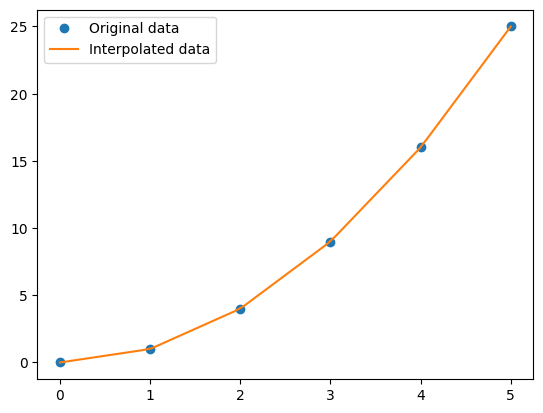

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
# Sample data (x and y)
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 1, 4, 9, 16, 25])
# Create an interpolation function
f = interp1d(x, y, kind='linear')
# New x values for interpolation
x_new = np.linspace(0, 5, 50)
# Interpolated y values
y_new = f(x_new)
# Plot the original data and the interpolated points
plt.plot(x, y, 'o', label='Original data')
plt.plot(x_new, y_new, '-', label='Interpolated data')
plt.legend()
plt.show()

In [3]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm

def interpolate_spectrum(fluxes_loc, frequencies_loc, output_dir, limit=10, edge_limit=20):
    """Interpolates the flux values to fill in missing data points."""
    # Load the data from the pickle file    
    df_freq = pd.read_pickle(frequencies_loc).reset_index(drop=True)      
    df_freq = df_freq.drop(columns=['row'])
    df_flux = pd.read_pickle(fluxes_loc).reset_index(drop=True)  # Reset index for zero-based iteration
    df_flux = df_flux.drop(columns=['row'])

    # Initialize an empty list to store the results before concatenating into a DataFrame
    results_list = []

    # Initialize lists to store problematic file_names
    nan_files = []  

    # Count the number of successful interpolations
    cnt_success = 0

    # Debugging counters
    cnt_total_skipped = 0
    cnt_nan_skipped = 0
    cnt_zero_skipped = 0

    # Overwrite the output file at the beginning
    if os.path.exists(output_dir):
        os.remove(output_dir)

    # Loop through each row in the DataFrame (each row is a spectrum) with tqdm for progress bar
    for index, row in tqdm(df_flux.iterrows(), total=len(df_flux), desc='Interpolating spectra'):

        # Extract the fluxes (assuming they start at column 0 and continue to the last column)
        fluxes = row[:-2].values  # Exclude the last columns (file_name, label)

        # Extract the frequencies
        frequencies = df_freq.iloc[int(index), :-2].values  # Exclude the last columns (file_name, label)

        # Count the number of NaN and 0 values in the fluxes and frequencies
        fluxes = pd.to_numeric(row[:-2], errors='coerce').values  # Exclude and convert to numeric
        frequencies = pd.to_numeric(df_freq.iloc[index, :-2], errors='coerce').values  # Same for frequencies
        num_nan = np.isnan(fluxes).sum() + np.isnan(frequencies).sum()  # Count NaN values
        num_zero = (fluxes == 0).sum() + (frequencies == 0).sum()  # Count zero values
        num_freq_nan = np.isnan(frequencies).sum() + (frequencies == 0).sum()
        if num_freq_nan > 0:
            print(f"Number of NaN or zero frequency values: {num_freq_nan}")
        # Special handling for NaN values, counting nans in sequence, except for the first and last 10
        if num_nan > limit and index > edge_limit and index < len(fluxes)-edge_limit:
            cnt_nan_skipped += 1  # Debug: count NaN-skipped rows
            nan_files.append(row['file_name'])
            continue
        
        if num_zero > limit and index > edge_limit and index < len(fluxes)-edge_limit:
            cnt_zero_skipped += 1  # Debug: count zero-skipped rows
            nan_files.append(row['file_name'])
            continue

        # Deal with NaN values
        fluxes = fluxes[~np.isnan(fluxes)]
        frequencies = frequencies[~np.isnan(fluxes)]

        # Interpolate to fill in missing values
        f = interp1d(frequencies, fluxes, kind='linear', fill_value="extrapolate")
        new_frequencies = np.linspace(frequencies.min(), frequencies.max(), len(row[:-2].values))

        # Interpolated flux values
        interpolated_fluxes = f(new_frequencies)

        # Store the interpolated data along with labels and other metadata
        # Create a dictionary for the interpolated spectrum
        interpolated_data = {f'flux_{i}': value for i, value in enumerate(interpolated_fluxes)}

        # Add the original metadata back (e.g., file_name, label, row)
        interpolated_data['file_name'] = row['file_name']
        interpolated_data['label'] = row['label']
        
        # Append the interpolated data to the results list
        results_list.append(interpolated_data)

        if index % 2000 == 0:  # Save every 5000 rows
            if os.path.exists(output_dir):
                existing_df = pd.read_pickle(output_dir)  # Load existing data
                new_df = pd.DataFrame(results_list)
                # Concatenate existing and new data
                combined_df = pd.concat([existing_df, new_df], ignore_index=True)
                combined_df.to_pickle(output_dir)  # Save combined DataFrame
            else:
                # If the file doesn't exist, create a new DataFrame and save
                pd.DataFrame(results_list).to_pickle(output_dir)
            cnt_success += len(results_list)  # Increment the count of successful interpolations
            results_list = []  # Clear list to free memory

    print(f"Initial number of rows: {len(df_flux)}")

    # After the loop, save any remaining results
    if results_list:
        if os.path.exists(output_dir):
            existing_df = pd.read_pickle(output_dir)
            new_df = pd.DataFrame(results_list)
            combined_df = pd.concat([existing_df, new_df], ignore_index=True)
            combined_df.to_pickle(output_dir)
        else:
            pd.DataFrame(results_list).to_pickle(output_dir)
        cnt_success += len(results_list)

    # Debugging information
    cnt_total_skipped = len(nan_files)
    print(f"Total successful interpolations: {cnt_success}")
    print(f"Total skipped due to NaNs: {cnt_nan_skipped}")
    print(f"Total skipped due to zeros: {cnt_zero_skipped}")
    print(f"Total skipped rows (NaNs + zeros): {cnt_total_skipped}")
    print(f"Final check: len(df_flux) == cnt_success + len(nan_files)? {len(df_flux) == cnt_success + cnt_total_skipped}")

    return nan_files


In [4]:
flux_loc = 'Pickles/lmst/flux_gal_df.pkl'
freq_loc = 'Pickles/lmst/freq_gal_df.pkl'
output_dir = 'Pickles/lmst/interpolated_data/train_gal.pkl'

tgalnan = interpolate_spectrum(flux_loc, freq_loc, output_dir, limit=10)

Interpolating spectra: 100%|██████████| 1699/1699 [00:06<00:00, 262.02it/s]


Initial number of rows: 1699
Total successful interpolations: 1621
Total skipped due to NaNs: 0
Total skipped due to zeros: 78
Total skipped rows (NaNs + zeros): 78
Final check: len(df_flux) == cnt_success + len(nan_files)? True


In [26]:
flux_loc = 'Pickles/lmst/flux_bin_df.pkl'
freq_loc = 'Pickles/lmst/freq_bin_df.pkl'
output_dir = 'Pickles/lmst/interpolated_data/train_bin.pkl'

tbinnan = interpolate_spectrum(flux_loc, freq_loc, output_dir, limit=10)

Interpolating spectra: 100%|██████████| 40676/40676 [04:26<00:00, 152.60it/s]


Initial number of rows: 40676
Total successful interpolations: 40554
Total skipped due to NaNs: 0
Total skipped due to zeros: 122
Total skipped rows (NaNs + zeros): 122
Final check: len(df_flux) == cnt_success + len(nan_files)? True


In [27]:
flux_loc = 'Pickles/lmst/flux_agn_df.pkl'
freq_loc = 'Pickles/lmst/freq_agn_df.pkl'
output_dir = 'Pickles/lmst/interpolated_data/train_agn.pkl'

tagnnan = interpolate_spectrum(flux_loc, freq_loc, output_dir, limit=10)

Interpolating spectra: 100%|██████████| 35936/35936 [03:58<00:00, 150.84it/s]


Initial number of rows: 35936
Total successful interpolations: 35811
Total skipped due to NaNs: 0
Total skipped due to zeros: 125
Total skipped rows (NaNs + zeros): 125
Final check: len(df_flux) == cnt_success + len(nan_files)? True


# Code specific for large stars df

In [7]:
flux_loc = 'Pickles/lmst/flux_star_df.pkl'
freq_loc = 'Pickles/lmst/freq_star_df.pkl'
output_dir = 'Pickles/lmst/interpolated_data/train_star.pkl'    

df_freq = pd.read_pickle(freq_loc).reset_index(drop=True)      
df_freq = df_freq.drop(columns=['row'])


# Saave the data to a csv file
df_freq.to_csv('Pickles/lmst/freq_star_df.csv')

In [10]:
del df_freq
gc.collect()
df_flux = pd.read_pickle(flux_loc).reset_index(drop=True)  # Reset index for zero-based iteration
df_flux = df_flux.drop(columns=['row'])
df_flux.to_csv('Pickles/lmst/flux_star_df.csv')

In [11]:
del df_flux
gc.collect()


0

### csv version

In [24]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm

def interpolate_spectrum_in_chunks(fluxes_loc, frequencies_loc, output_dir, chunk_size=5000, limit=10, edge_limit=20):
    """Interpolates the flux values to fill in missing data points, processing the CSV file in chunks."""
    nan_files = []  # To store the names of files with issues

    # Overwrite the output file if it exists
    if os.path.exists(output_dir):
        os.remove(output_dir)

    # Read the CSV files in chunks, using the first column as the index
    flux_chunks = pd.read_csv(fluxes_loc, chunksize=chunk_size, index_col=0)
    freq_chunks = pd.read_csv(frequencies_loc, chunksize=chunk_size, index_col=0)

    # Process each chunk
    for flux_chunk, freq_chunk in zip(tqdm(flux_chunks, desc="Processing chunks"), freq_chunks):
        # Ensure both chunks have the same length
        if len(flux_chunk) != len(freq_chunk):
            raise ValueError("Flux and frequency chunks have different sizes!")

        results_list = []  # To store results for the current chunk

        # Iterate over each row in the chunk
        for idx, row in flux_chunk.iterrows():

            # Extract fluxes (excluding 'file_name' and 'label' columns explicitly)
            fluxes = row.drop(['file_name', 'label']).values  

            # Extract corresponding frequencies using the same index and exclude metadata columns
            frequencies = freq_chunk.loc[idx].drop(['file_name', 'label']).values  

            # Handle NaN values in fluxes and frequencies
            fluxes = pd.to_numeric(fluxes, errors='coerce')
            frequencies = pd.to_numeric(frequencies, errors='coerce')

            num_nan = np.isnan(fluxes).sum() + np.isnan(frequencies).sum()
            num_zero = (fluxes == 0).sum() + (frequencies == 0).sum()

            # Check for too many NaNs or zeros and skip if necessary
            if num_nan > limit or num_zero > limit:
                nan_files.append(row['file_name'])
                continue

            # Remove NaN values
            valid_fluxes = fluxes[~np.isnan(fluxes)]
            valid_frequencies = frequencies[~np.isnan(frequencies)]

            # Interpolation
            f = interp1d(valid_frequencies, valid_fluxes, kind='linear', fill_value="extrapolate")
            new_frequencies = np.linspace(valid_frequencies.min(), valid_frequencies.max(), len(fluxes))

            interpolated_fluxes = f(new_frequencies)

            # Store the interpolated data along with metadata
            interpolated_data = {f'flux_{i}': value for i, value in enumerate(interpolated_fluxes)}
            interpolated_data['file_name'] = row['file_name']
            interpolated_data['label'] = row['label']
            results_list.append(interpolated_data)

        # Save the results to the output file
        results_df = pd.DataFrame(results_list)
        if os.path.exists(output_dir):
            existing_df = pd.read_pickle(output_dir)
            combined_df = pd.concat([existing_df, results_df], ignore_index=True)
            combined_df.to_pickle(output_dir)
        else:
            results_df.to_pickle(output_dir)

    return nan_files


In [25]:
flux_loc = 'Pickles/lmst/flux_star_df.csv'
freq_loc = 'Pickles/lmst/freq_star_df.csv'
output_dir = 'Pickles/lmst/interpolated_data/train_star.pkl'


tstarnan = interpolate_spectrum_in_chunks(flux_loc, freq_loc, output_dir, limit=10)

Processing chunks: 18it [08:34, 28.61s/it]


In [30]:
# save all the nan files to a simple list pickle file
nan_files = tgalnan + tbinnan + tagnnan + tstarnan
pd.to_pickle(nan_files, 'Pickles/drops/lamost.pkl')

# Remove the gaia nan files from the lamost interpolated data files

In [38]:
# open the pkl file with the list of files to drop
nan_gaia = pd.read_pickle("Pickles/drops/gaiaall.pkl")
num_to_remove = len(nan_gaia)
num_removed = 0


# Training dataset
# GALAXIES
df = pd.read_pickle('Pickles/lmst/interpolated_data/train_gal.pkl')
lenghtpre = len(df)
df = df[~df['file_name'].isin(nan_gaia)]    
print(f"GALAXIES: Number of rows before dropping: {lenghtpre} and after dropping: {len(df)}")
num_removed += lenghtpre - len(df)

# BINARY STARS
df = pd.read_pickle('Pickles/lmst/interpolated_data/train_bin.pkl')
lenghtpre = len(df)
df = df[~df['file_name'].isin(nan_gaia)]
print(f"BINARY STARS: Number of rows before dropping: {lenghtpre} and after dropping: {len(df)}")
num_removed += lenghtpre - len(df)

# AGNs
df = pd.read_pickle('Pickles/lmst/interpolated_data/train_agn.pkl')
lenghtpre = len(df)
df = df[~df['file_name'].isin(nan_gaia)]
print(f"AGNs: Number of rows before dropping: {lenghtpre} and after dropping: {len(df)}")
num_removed += lenghtpre - len(df)

# STARS
df = pd.read_pickle('Pickles/lmst/interpolated_data/train_star.pkl')
lenghtpre = len(df)
df = df[~df['file_name'].isin(nan_gaia)]
print(f"STARS: Number of rows before dropping: {lenghtpre} and after dropping: {len(df)}")
num_removed += lenghtpre - len(df)

print(f"Total number of rows removed: {num_removed} out of {num_to_remove}")


GALAXIES: Number of rows before dropping: 1621 and after dropping: 1620
BINARY STARS: Number of rows before dropping: 40554 and after dropping: 40483
AGNs: Number of rows before dropping: 35811 and after dropping: 35806
STARS: Number of rows before dropping: 83162 and after dropping: 83008
Total number of rows removed: 231 out of 236


In [3]:
# Load the DataFrame from the pickle file
dfgal = pd.read_pickle('Pickles/lmst/interpolated_data/train_gal.pkl')
dfbin = pd.read_pickle('Pickles/lmst/interpolated_data/train_bin.pkl')
dfstar = pd.read_pickle('Pickles/lmst/interpolated_data/train_star.pkl')


FileNotFoundError: [Errno 2] No such file or directory: 'Pickles/lmst/interpolated_data/train_star.pkl'

In [4]:
del dfgal, dfbin, dfstar

NameError: name 'dfstar' is not defined

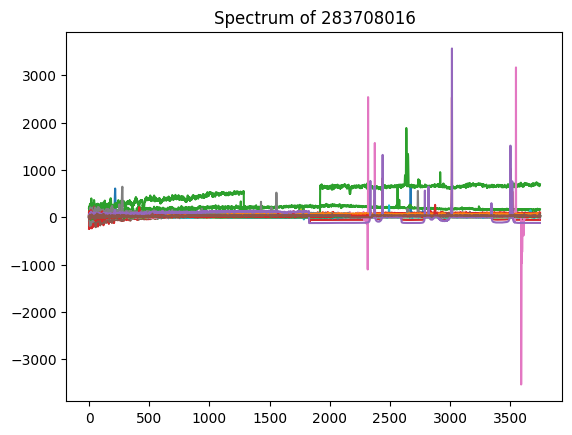

In [54]:
import matplotlib.pyplot as plt
df_flux = pd.read_pickle(flux_loc).reset_index(drop=True)  # Reset index for zero-based iteration
# Plot the spectrum of files that have more than 10 zero values in sequence and make a npy array
nparray = []
for file_name in tgalnan:
    # Find the row corresponding to the file_name
    row = df_flux[df_flux['file_name'] == file_name].iloc[0]
    # Extract the flux values
    flux_values = row[:-3].values
    # Save into a NumPy array
    nparray.append(np.array(flux_values))
    # Plot the flux values
    plt.plot(flux_values, label=file_name)
    plt.title(f"Spectrum of {file_name}")
    #plt.show()
nparray = np.array(nparray)

In [20]:
if int(index/3) % 100 == 0:  # Save every 100 rows
    pd.DataFrame(results_list).to_pickle(output_dir, mode='a')  # Save in append mode
    results_list = []  # Clear list to free memory


NameError: name 'index' is not defined

In [3]:
import gc
gc.collect()

31

# Print spectra that failed

# Normalize spectra

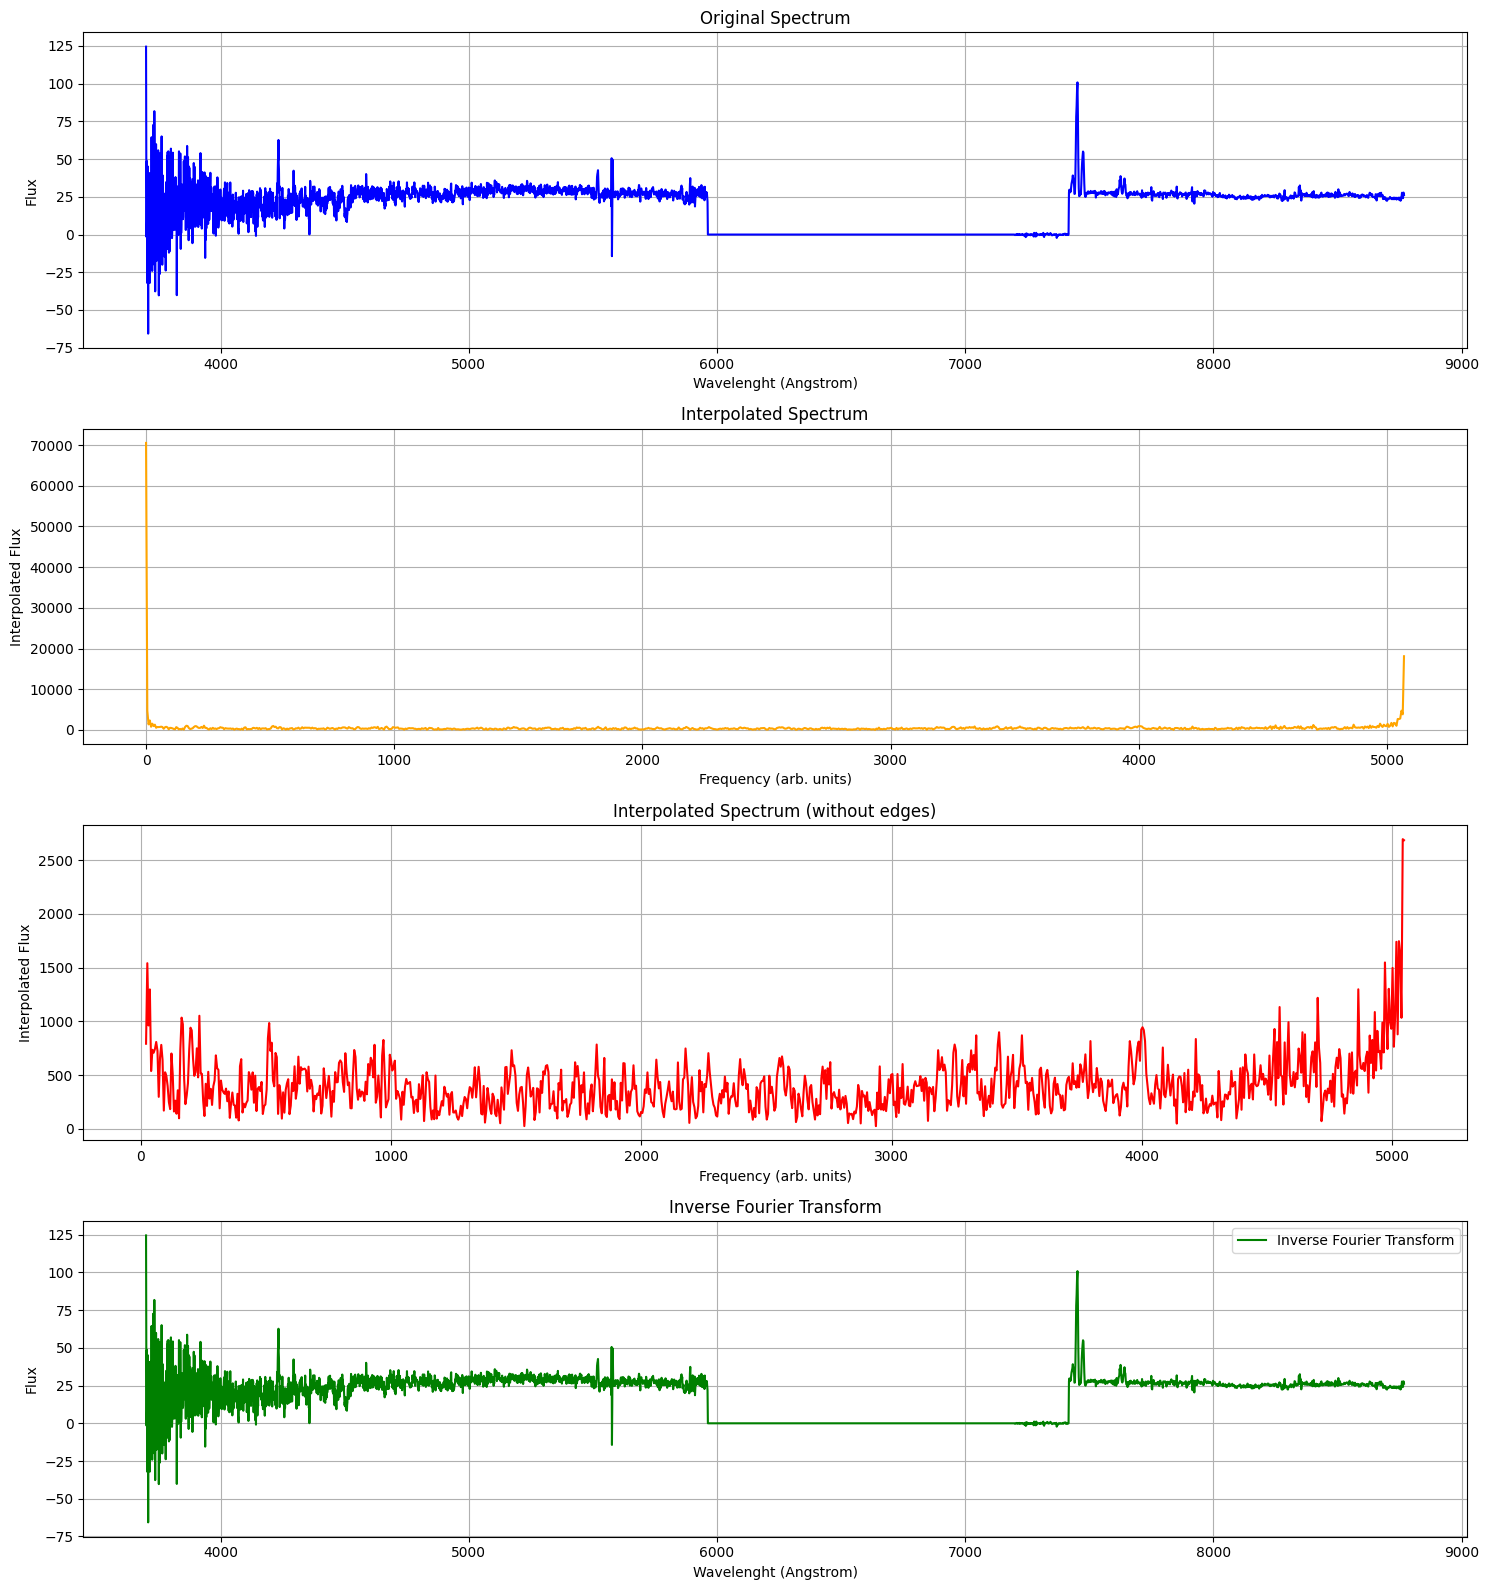

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d

# Load the original and interpolated data
original_df = pd.read_pickle('Pickles/lmst/flux_gal_df.pkl')  # adjust the filename as needed
original_df_freq = pd.read_pickle('Pickles/lmst/freq_gal_df.pkl')  # adjust the filename as needed
interpolated_df = pd.read_pickle('interpolated_spectra_data.pkl')  # Loaded from previous steps

# Select a spectrum index to plot (for example, the first spectrum)
spectrum_index = 2

# Original data
original_flux = original_df.iloc[spectrum_index, :-3].values  # Exclude the last columns (file_name, label, row)
original_frequencies = original_df_freq.iloc[spectrum_index, :-3].values  # Exclude the last columns (file_name, label, row)

# Interpolated data
interpolated_flux = interpolated_df.iloc[spectrum_index, :-3].values  # Exclude the last columns (fft_mag_x)
new_frequencies = np.linspace(0, (original_frequencies.max()-original_frequencies.min()), len(interpolated_flux))
                                  

# Inverse Fourier Transform
# Note: Assuming original_flux was DFT transformed, here we just show ifft of the DFT
flux_fft = fft(original_flux)
ifft_flux = ifft(flux_fft)

# Plotting
plt.figure(figsize=(15, 16))

# Plot Original Spectrum
plt.subplot(4, 1, 1)
plt.plot(original_frequencies, original_flux, label='Original Spectrum', color='blue')
plt.title('Original Spectrum')
plt.xlabel('Wavelenght (Angstrom)')
plt.ylabel('Flux')
plt.grid()

# Plot Interpolated Spectrum
plt.subplot(4, 1, 2)
plt.plot(new_frequencies, interpolated_flux, label='Fourier transform', color='orange')
plt.title('Interpolated Spectrum')
plt.xlabel('Frequency (arb. units)')
plt.ylabel('Interpolated Flux')
plt.grid()

# Plot Interpolated Spectrum without edges
plt.subplot(4, 1, 3)
plt.plot(new_frequencies[4:-4], interpolated_flux[4:-4], label='Interpolated Spectrum (without edges)', color='red')
plt.title('Interpolated Spectrum (without edges)')
plt.xlabel('Frequency (arb. units)')
plt.ylabel('Interpolated Flux')
plt.grid()


# Plot Inverse Fourier Transform
plt.subplot(4, 1, 4)
plt.plot(original_frequencies, ifft_flux.real, label='Inverse Fourier Transform', color='green')
plt.title('Inverse Fourier Transform')
plt.xlabel('Wavelenght (Angstrom)')
plt.ylabel('Flux')
plt.grid()

plt.tight_layout()
plt.legend()
plt.show()
